# GraPL Scratchpad

## Imports and Constants

In [2]:
%env CUDA_LAUNCH_BLOCKING=1
%env CUBLAS_WORKSPACE_CONFIG=:4096:8
%load_ext line_profiler
%load_ext autoreload
%autoreload 2
from GraPL import GraPL_Segmentor, side_by_side, view_multichannel, PatchDL, GraPLNet
import glob
import tqdm
import matplotlib.pyplot as plt
from GraPL.evaluate import *
import numpy as np
import warnings
import torch
import pandas as pd
warnings.filterwarnings("ignore")

env: CUDA_LAUNCH_BLOCKING=1
env: CUBLAS_WORKSPACE_CONFIG=:4096:8


## Testbench

Fitting...
Predicting...
CPU times: user 1.54 ms, sys: 949 µs, total: 2.49 ms
Wall time: 19.8 ms


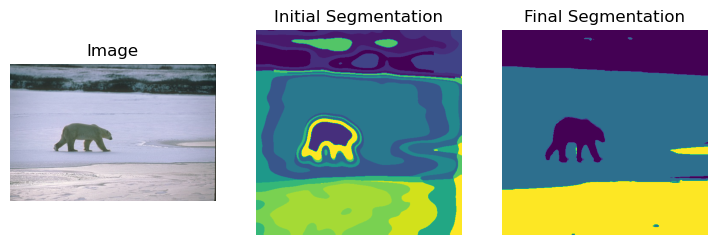

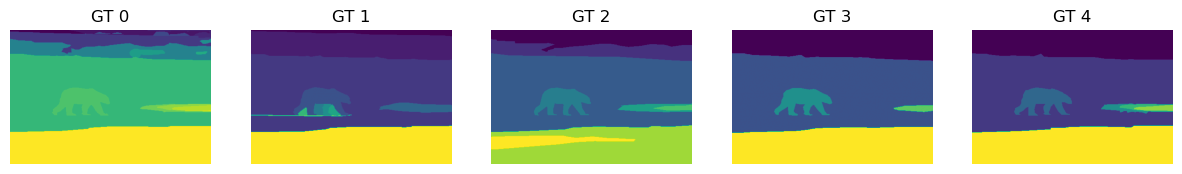

{'f1_score': 0.2529967156972036, 'accuracy': 0.3884482613454576, 'jaccard': 0.17096134965624069, 'v_measure': 0.5265904496964353, 'segmentation_covering': 0.2640099058824639, 'variation_of_information': 1.3453215758946382, 'probabalistic_rand_index': 0.7501902689595055, 'proportional_potts_energy': 0.02749047124047124, 'delta_k': nan, 'k_error': -0.9117177559282823, 'training_time': nan, 'prediction_time': nan, 'total_time': nan}


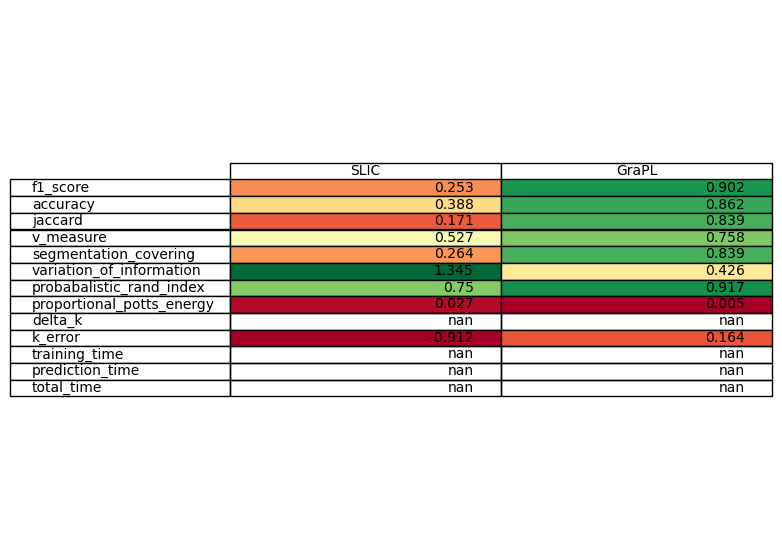

Timer unit: 1e-09 s

Total time: 2.24645 s
File: /Users/isaac/Desktop/GraPL All/GraPL/GraPL/GraPL.py
Function: fit at line 560

Line #      Hits         Time  Per Hit   % Time  Line Contents
   560                                               def fit(self, image):
   561                                                   """Fits the network to the image
   562                                           
   563                                                   In this minimal example, the fit method standardizes the image, generates labels using `inital_labels()` (SLIC), and trains the network in a supervised manner, using cross entropy loss.
   564                                           
   565                                                   Args:
   566                                                       image (ndarray): input image represented by a (H,W,C) array
   567                                                   """
   568         1       1000.0   1000.0      0.0         

In [36]:
id = "100007"
image = plt.imread(f"datasets/BSDS500/BSDS500/data/images/test/{id}.jpg")

params = {
    'iterations': 4,
    'k': 14,
    'd': 32,
    'lambda_': 64,
    'subset_size': 0.5,
    'max_epochs': 40,
    'min_epochs': 12,
    'n_filters': 32,
    'bottleneck_dim': 8,
    'compactness': 0.1,
    'sigma': 10,
    'seed': 0,
    'use_continuity_loss': True,
    'continuity_range': 1,
    'continuity_p': 1,
    'continuity_weight': 2,
    'use_min_loss': True,
    'use_coords': False,
    'use_embeddings': False,
    'use_color_distance_weights': True,
    'initialization_method': 'slic',
    'use_fully_connected': True,
    'use_collapse_penalty': False,
    'use_cold_start': False,
    'num_layers': 3,
    'use_graph_cut': True
}

segmentor = GraPL_Segmentor(**params)

print("Fitting...")
%lprun -f segmentor.fit segmentor.fit(image)

print("Predicting...")
%time seg = segmentor.predict()

torch.cuda.empty_cache()

side_by_side([image, segmentor.initial_segmentation, seg], titles=["Image", "Initial Segmentation", "Final Segmentation"])

if segmentor.embeddings is not None:
    e = segmentor.embeddings.reshape(segmentor.d, segmentor.d, -1)
    view_multichannel(e / e.max())

gt_paths = glob.glob(f"datasets/BSDS500/gt/{id}-*.csv")
gts = []
for path in gt_paths:
    gts.append(np.loadtxt(path, delimiter=','))
side_by_side(gts, titles=[f"GT {i}" for i in range(len(gts))])

slic_scores = bsds_score(id, segmentor.initial_segmentation)
print(slic_scores)
slic_scores = {key: np.mean(slic_scores[key]) for key in slic_scores}
grapl_scores = bsds_score(id, seg)
grapl_scores = {key: np.mean(grapl_scores[key]) for key in grapl_scores}

df = pd.DataFrame([slic_scores, grapl_scores], index=["SLIC", "GraPL"])
df = df.transpose()
df = df.round(3)
plt.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', cellColours=plt.cm.RdYlGn(df.values))
plt.axis('off')
plt.show()

In [3]:
with open("datasets/PascalVOC2012/VOC2012/ImageSets/Segmentation/val.txt", "r") as f:
    val_image_ids = f.read().split("\n")

Fitting...
Predicting...


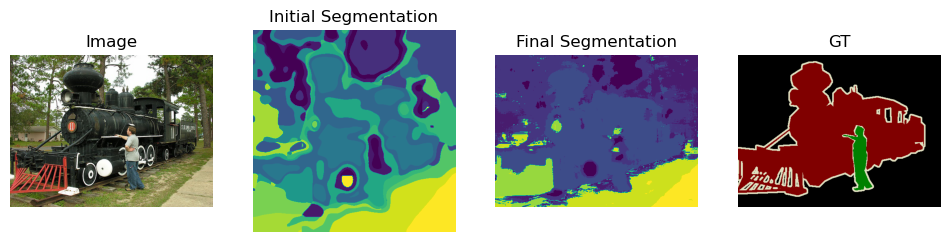

[0. 1. 2. 3.]


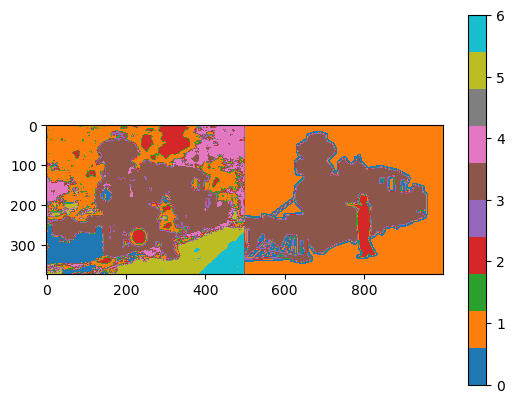

Score: tensor(0.5152)


In [19]:
id = val_image_ids[81]
segmentation_mode = "SegmentationObject"
image = plt.imread(f"datasets/PascalVOC2012/VOC2012/JPEGImages/{id}.jpg")
gt = plt.imread(f"datasets/PascalVOC2012/VOC2012/{segmentation_mode}/{id}.png")

params = {
    'iterations': 4,
    'k': 14,
    'd': 32,
    'lambda_': 64,
    'subset_size': 0.5,
    'max_epochs': 40,
    'min_epochs': 12,
    'n_filters': 32,
    'bottleneck_dim': 8,
    'compactness': 0.1,
    'sigma': 10,
    'seed': 0,
    'use_continuity_loss': True,
    'continuity_range': 1,
    'continuity_p': 1,
    'continuity_weight': 2,
    'use_min_loss': True,
    'use_coords': False,
    'use_embeddings': False,
    'use_color_distance_weights': True,
    'initialization_method': 'slic',
    'use_fully_connected': True,
    'use_collapse_penalty': False,
    'use_cold_start': False,
    'num_layers': 3,
    'use_graph_cut': True
}

segmentor = GraPL_Segmentor(**params)

print("Fitting...")
segmentor.fit(image)

print("Predicting...")
seg = segmentor.predict()

torch.cuda.empty_cache()

def evaluate_voc_segmentation(seg, id, segmentation_mode):
    gt = plt.imread(f"datasets/PascalVOC2012/VOC2012/{segmentation_mode}/{id}.png")
    # Reformat ground truth
    colors = np.unique(gt.reshape(-1, gt.shape[2]), axis=0)
    ignore_mask = np.isclose(gt, [0.8784314, 0.8784314, 0.7529412, 1.       ], atol=0.01).all(axis=2)
    background_mask = np.isclose(gt, [0, 0, 0, 1], atol=0.01).all(axis=2)
    object_colors = colors[~np.isclose(colors, [0, 0, 0, 1], atol=0.01).all(axis=1)]
    object_colors = object_colors[~np.isclose(object_colors, [0.8784314, 0.8784314, 0.7529412, 1], atol=0.01).all(axis=1)]
    integer_gt = np.zeros_like(gt[:, :, 0])
    integer_gt[ignore_mask] = 0
    integer_gt[background_mask] = 1
    for i in range(len(object_colors)):
        mask_index = i + 2
        integer_gt[np.isclose(gt, object_colors[i], atol=0.01).all(axis=2)] = mask_index
    print(np.unique(integer_gt))
    miou = jaccard(seg, integer_gt, resize=True, match_segments=True, ignore_indices=[0])
    return miou

side_by_side([image, segmentor.initial_segmentation, seg, gt], titles=["Image", "Initial Segmentation", "Final Segmentation", "GT"])

miou = evaluate_voc_segmentation(seg, id, segmentation_mode)
print("Score:", miou)